# Time series of reanalysis data from 20CR project
- calculate anomalies of temperature for monthly data from the 20CR project 
- do this for four spatial regions 
- then plot results with percentile range 

## the notebook loads the data and calculates anomalies, and does some plots
## the anomaly function increases the number of chunks  when using groupby so it's super inefficient
- plots work for 10 members and final plot (of global temp with percentiles) takes 15 min to plot and didn't work for 30 members
## land mask is now working 
- needed to reverse the order of the lat bounds cos the array is arranged in reverse (90, -90).
- also needed to regrid the file

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/ua8/C20C/v3/member_monthly/PRATE/1850

PRATE.1850.mnmean_mem001.nc  PRATE.1850.mnmean_mem041.nc
PRATE.1850.mnmean_mem002.nc  PRATE.1850.mnmean_mem042.nc
PRATE.1850.mnmean_mem003.nc  PRATE.1850.mnmean_mem043.nc
PRATE.1850.mnmean_mem004.nc  PRATE.1850.mnmean_mem044.nc
PRATE.1850.mnmean_mem005.nc  PRATE.1850.mnmean_mem045.nc
PRATE.1850.mnmean_mem006.nc  PRATE.1850.mnmean_mem046.nc
PRATE.1850.mnmean_mem007.nc  PRATE.1850.mnmean_mem047.nc
PRATE.1850.mnmean_mem008.nc  PRATE.1850.mnmean_mem048.nc
PRATE.1850.mnmean_mem009.nc  PRATE.1850.mnmean_mem049.nc
PRATE.1850.mnmean_mem010.nc  PRATE.1850.mnmean_mem050.nc
PRATE.1850.mnmean_mem011.nc  PRATE.1850.mnmean_mem051.nc
PRATE.1850.mnmean_mem012.nc  PRATE.1850.mnmean_mem052.nc
PRATE.1850.mnmean_mem013.nc  PRATE.1850.mnmean_mem053.nc
PRATE.1850.mnmean_mem014.nc  PRATE.1850.mnmean_mem054.nc
PRATE.1850.mnmean_mem015.nc  PRATE.1850.mnmean_mem055.nc
PRATE.1850.mnmean_mem016.nc  PRATE.1850.mnmean_mem056.nc
PRATE.1850.mnmean_mem017.nc  PRATE.1850.mnmean_mem057.nc
PRATE.1850.mnmean_mem018.nc  PR

In [4]:
# Create a list with all the strings identifying your members
# use a combination of range and zfill to get the leading zeros.
member_list = [str(x).zfill(2) for x in range(1,81)]

In [5]:
member_list = member_list#[slice(0,10)]
member_list

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80']

### So I can plot the precipitation time series for the entire time period of 1850-2015 (without the kernel dying). But it still takes a while to plot (at least 5 minutes, myabe up to 20min)

In [6]:
# load temp data
member_ds_t = {}
for i in member_list:
    path = f'/g/data/ua8/C20C/v3/member_monthly`/TMPS/*/*_mem0{i}.nc'
    member_ds_t[i] = xr.open_mfdataset(path, parallel=True)
    member_ds_t[i] = member_ds_t[i].chunk(chunks={'time':-1, 'lat':100, 'lon':100})

In [32]:
path = f'/g/data/ua8/C20C/v3/member_monthly/TMPS/1850/*_mem0*.nc'
data1 = xr.open_mfdataset(path, parallel=True, concat_dim=['lat','lon','time']).chunk(chunks={'time':-1, 'lat':100, 'lon':100})
data1

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [11]:
path = f'/g/data/ua8/C20C/v3/member_monthly/TMPS/*/*_mem0*.nc'
data = xr.open_mfdataset(path, parallel=True).chunk(chunks={'time':-1, 'lat':100, 'lon':100})
data

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 182 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 182 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 512, lon: 1023, time: 1992)
Coordinates:
  * lat        (lat) float64 -89.46 -89.46 -88.77 -88.77 ... 88.77 89.46 89.46
  * lon        (lon) float64 0.0 0.703 0.7031 1.406 ... 358.5 358.6 359.2 359.3
  * time       (time) datetime64[ns] 1850-01-16T10:30:00 ... 2015-12-16T10:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (lon, lat, time, bnds) datetime64[ns] dask.array<chunksize=(100, 100, 1992, 2), meta=np.ndarray>
    TMP        (time, lat, lon) float32 dask.array<chunksize=(1992, 100, 100), meta=np.ndarray>
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.3 (http://mpimet.mpg.d...
    history:        Sun Dec 23 02:29:36 2018: cdo -v -f nc4 -r -monavg TMPS.1...
    institution:    NOAA ESRL Physical Sciences Division & CU/CIRES \n
    Conventions:    CF-1.6
    platform:       Model
    citation:       <http://onlinelibrary.wiley.com/doi/10.1002/qj.776/abstra...
    ...             ...
    observations:   International Surface Pressure Databank version 4.7
    frequency:      mon
    CDO:            Climate Data Operators version 1.9.3 (http://mpimet.mpg.d...
    comments:       Data is from \n NOAA-CIRES-DOE 20th Century Reanalysis ve...
    main_citation:  <https://doi.org/10.1002/qj.3598>.\n Slivinski et al. 201...
    home_page:      <https://go.usa.gov/XTd>

In [16]:
data = data.rename({'TMP':'tmp'})
data

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 512, lon: 1023, time: 1992)
Coordinates:
  * lat        (lat) float64 -89.46 -89.46 -88.77 -88.77 ... 88.77 89.46 89.46
  * lon        (lon) float64 0.0 0.703 0.7031 1.406 ... 358.5 358.6 359.2 359.3
  * time       (time) datetime64[ns] 1850-01-16T10:30:00 ... 2015-12-16T10:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (lon, lat, time, bnds) datetime64[ns] dask.array<chunksize=(100, 100, 1992, 2), meta=np.ndarray>
    tmp        (time, lat, lon) float32 dask.array<chunksize=(1992, 100, 100), meta=np.ndarray>
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.3 (http://mpimet.mpg.d...
    history:        Sun Dec 23 02:29:36 2018: cdo -v -f nc4 -r -monavg TMPS.1...
    institution:    NOAA ESRL Physical Sciences Division & CU/CIRES \n
    Conventions:    CF-1.6
    platform:       Model
    citation:       <http://onlinelibrary.wiley.com/doi/10.1002/qj.776/abstra...
    ...             ...
    observations:   International Surface Pressure Databank version 4.7
    frequency:      mon
    CDO:            Climate Data Operators version 1.9.3 (http://mpimet.mpg.d...
    comments:       Data is from \n NOAA-CIRES-DOE 20th Century Reanalysis ve...
    main_citation:  <https://doi.org/10.1002/qj.3598>.\n Slivinski et al. 201...
    home_page:      <https://go.usa.gov/XTd>

In [17]:
data = data.tmp

In [21]:
data

<xarray.DataArray 'tmp' (time: 1992, lat: 512, lon: 1023)>
dask.array<rechunk-merge, shape=(1992, 512, 1023), dtype=float32, chunksize=(1992, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.46 -89.46 -88.77 -88.77 ... 88.77 89.46 89.46
  * lon      (lon) float64 0.0 0.703 0.7031 1.406 ... 358.5 358.6 359.2 359.3
  * time     (time) datetime64[ns] 1850-01-16T10:30:00 ... 2015-12-16T10:30:00
Attributes:
    standard_name:       air_temperature
    long_name:           Temperature
    units:               K
    param:               0.0.0
    realization:         80
    ensemble_members:    10
    forecast_init_type:  3
    original_name:       t

In [7]:
# concatenate the data into an xarray with the new member dimension
# the dask line reduces the size of the chunks and hopefully allows tmp to be plotted without the kernel dying
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_tmps = xr.concat(member_ds_t.values(), dim='member')
ds_tmps.coords['member'] = member_list


In [8]:
ds_tmps.TMP

,Array,Chunk
Bytes,333.88 GB,79.68 MB
Shape,"(80, 1992, 512, 1023)","(1, 1992, 100, 100)"
Count,92295 Tasks,10240 Chunks
Type,float32,numpy.ndarray


In [ ]:
reanal = reanal.rename({'TMP':'tmp'})

In [9]:
# combine precipitation and temperature into one dataset
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):
reanal = xr.Dataset({'tmp': ds_tmps.TMP})

In [10]:
reanal.tmp

,Array,Chunk
Bytes,333.88 GB,79.68 MB
Shape,"(80, 1992, 512, 1023)","(1, 1992, 100, 100)"
Count,92295 Tasks,10240 Chunks
Type,float32,numpy.ndarray


## kernel dies when I try to write the data to a netcdf

In [ ]:
ds_tmps.to_netcdf(f'/g/data/w48/kb6999/20CR_data_netcdfs/R_ts_tmp.nc')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/conventions.py:441: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x7fb1676b3c10>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 238, in __del__
    ref_count = self._ref_counter.decrement(self._key)
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'


## Area weighting and land frac

In [30]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_ds

In [14]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))

In [15]:
# data1 = reanal_w.sel(time=slice('1850-01','1900-01')).mean(dim=['lat','lon','member'])

When I had tmp and pr combined in a dataset and then tried to just plot pr, it didn't work, the kernel died.  I'll try the same thing, but without tmp in the datset and see if it works!!

In [18]:
# fig, axes = plt.subplots(1, 1) # make a figure
# with dask.diagnostics.ProgressBar():
#     data1.tmp.plot(ax=axes)

In [19]:
# #dir(data1.tmp)
# #data1.tmp[:10].to_masked_array()
# data1.tmp.shape
# data1 = data1.tmp.chunk(chunks={'time':200})


In [20]:
# data1[0:10].values

## Group the data by month

In [21]:
# group the data by month (take the monthly mean)
reanal_mon = reanal_w.resample(time='M').mean(dim='time')

In [22]:
data_mon = data.resample(time='M').mean(dim='time')

In [23]:
data_mon

,Array,Chunk
Bytes,4.17 GB,40.00 kB
Shape,"(1992, 512, 1023)","(1, 100, 100)"
Count,712348 Tasks,131472 Chunks
Type,float32,numpy.ndarray


In [27]:
monthly_anom_glob = func.monthly_anomaly(data_mon, '1850-01', '1881-01')

In [ ]:
# monthly_anom_glob = monthly_anom_glob.load()

In [23]:
# fig, axes = plt.subplots(1, 1) # make a figure
# with dask.diagnostics.ProgressBar():
#     data1.tmp.plot(ax=axes)

In [24]:
# use functions to calculate the monthly anomalies for the globe
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    monthly_anom_glob = func.monthly_anomaly(reanal_mon, '1850-01', '1881-01')

In [25]:
# data = monthly_anom_glob.sel(time=slice('1850-01','1900-01')).mean(dim=['lat','lon','member'])

Again, when I had tmp and pr combined in a dataset and then tried to just plot pr, it didn't work, the kernel died. But again, I'll try the same thing, but without tmp in the datset and see if it works. 

temp doesn't plot, pr anomalies are all 0.  

[########################################] | 100% Completed |  4min  5.4s


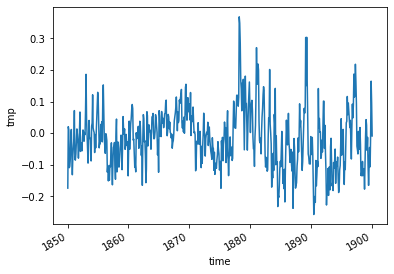

In [18]:
fig, axes = plt.subplots(1,1) # make a figure
with dask.diagnostics.ProgressBar():
    data.tmp.plot(ax=axes)

In [26]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(-90,0)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90)) 

In [31]:
# select out the Australian and E Australian anomalies 
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
    monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1, drop=True)

In [32]:
monthly_anom_Aus

,Array,Chunk
Bytes,199.84 MB,1.67 kB
Shape,"(1992, 10, 44, 57)","(1, 1, 22, 19)"
Count,3806860 Tasks,119520 Chunks
Type,float32,numpy.ndarray


## Multi-member mean


In [ ]:
# take the lat lon mean for mmm datsets for each region
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [ ]:
llm_Aus.to_netcdf(f'/g/data/w48/kb6999/20CR_data_netcdfs/R_ts_llm_Aus_tmp.nc')

In [22]:
# Take the multi-member mean for each region
mmm_mon_Glob = monthly_anom_glob.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_SH = monthly_anom_SH.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_NH = monthly_anom_NH.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_Aus = monthly_anom_Aus.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_EA = monthly_anom_EA.mean(dim='member').mean(dim=['lat','lon'])

## Percentiles

In [23]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.1, dim=['member'])

In [24]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.9, dim=['member'])

## Figures

In [25]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

[########################################] | 100% Completed |  5min 34.0s
[###################################     ] | 88% Completed |  4min 50.3s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 59.5s


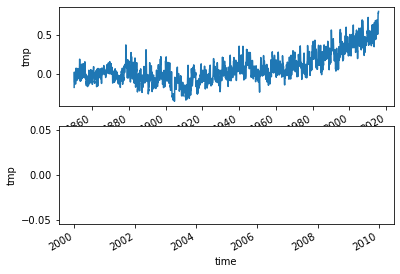

In [26]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(2, 1) # make a figure
with dask.diagnostics.ProgressBar():
    mmm_mon_Glob.tmp.plot(ax=axes[0])
    mmm_mon_Aus.tmp.plot(ax=axes[1])

In [27]:
fplot = reload(fplot) 

global plotted on it's own, but now we'll see if it can plot as a subplot

[########################################] | 100% Completed |  5min 12.3s
[########################################] | 100% Completed |  4min 58.0s
[########################################] | 100% Completed |  5min 24.3s
[                                        ] | 0% Completed | 20.9s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####################################    ] | 91% Completed |  4min 33.3s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed |  4min 43.7s
[                                        ] | 0% Completed | 16.1s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####################################    ] | 91% Completed |  4min 27.4s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed |  4min 36.3s
[###################################     ] | 88% Completed |  4min 46.1s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 55.0s
[                                        ] | 0% Completed | 28.0s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################                  ] | 55% Completed |  4min 52.0s


KeyboardInterrupt: 

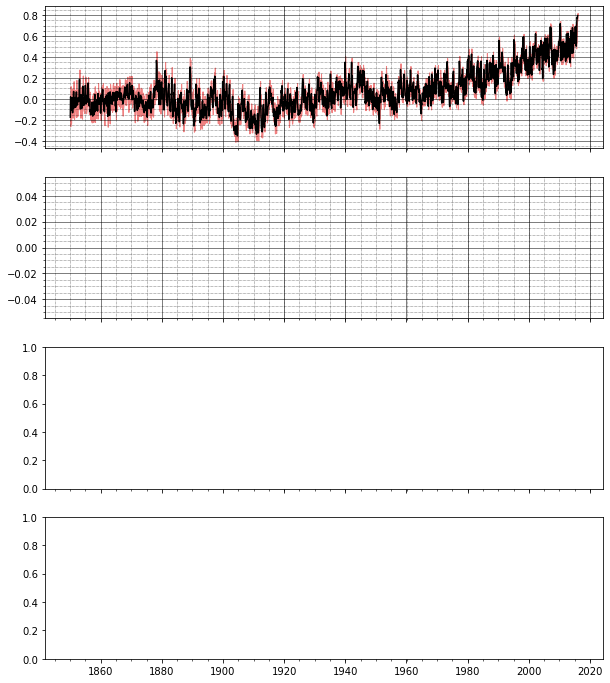

In [28]:
# Monthly temperature anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.tmp, p10_mon_Glob.tmp, p90_mon_Glob.tmp, ax = axes[0], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_SH.tmp, p10_mon_SH.tmp, p90_mon_SH.tmp, ax = axes[1], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_Aus.tmp, p10_mon_Aus.tmp, p90_mon_Aus.tmp, ax = axes[2], color='lightcoral')
    fplot.timeseries_graph(mmm_mon_EA.tmp, p10_mon_EA.tmp, p90_mon_EA.tmp, ax = axes[3], color='lightcoral')

axes[0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[1].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[3].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_tmp_stacked.png', dpi=300, bbox_inches='tight')

# Zoom in on Krakatoa years

In [ ]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [ ]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [ ]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [ ]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

In [ ]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.tmp, K_p10_Glob.tmp, K_p90_Glob.tmp, ax = axes[0,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_SH.tmp, K_p10_SH.tmp, K_p90_SH.tmp, ax = axes[0,1], color='lightcoral')
fplot.timeseries_graph(K_mmm_Aus.tmp, K_p10_Aus.tmp, K_p90_Aus.tmp, ax = axes[1,0], color='lightcoral')
fplot.timeseries_graph(K_mmm_EA.tmp, K_p10_EA.tmp, K_p90_EA.tmp, ax = axes[1,1], color='lightcoral')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_tmp.png', dpi=300, bbox_inches='tight')